In [5]:
!pip install transformers datasets torch pandas numpy emoji nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import MultiLabelBinarizer

In [7]:
# Download full dataset (211k samples)
dataset = load_dataset("go_emotions", "raw")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

In [8]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
        num_rows: 211225
    })
})


In [9]:
#Select only needed columns
emotion_columns = [
    'text',
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

# Filter the dataset
filtered_dataset = dataset['train'].select_columns(emotion_columns)

#Convert to Pandas DataFrame (optional)
df = pd.DataFrame(filtered_dataset)

In [10]:
print(df.columns)

Index(['text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
       'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
       'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride',
       'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')


neutral           55298
approval          17620
admiration        17131
annoyance         13618
gratitude         11625
disapproval       11424
curiosity          9692
amusement          9245
realization        8785
optimism           8715
disappointment     8469
love               8191
anger              8084
joy                7983
confusion          7359
sadness            6758
caring             5999
excitement         5629
surprise           5514
disgust            5301
desire             3817
fear               3197
remorse            2525
embarrassment      2476
nervousness        1810
pride              1302
relief             1289
grief               673
dtype: int64


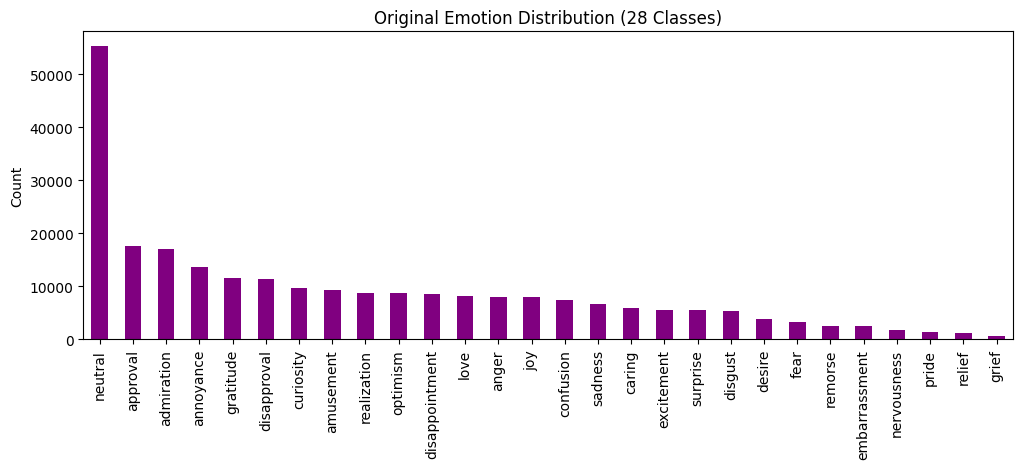

In [11]:
# Sum each emotion column (1 = present, 0 = absent)
emotion_distribution = df[['admiration', 'amusement', 'anger', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
       'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
       'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride',
       'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']].sum().sort_values(ascending=False)

# Print counts
print(emotion_distribution)

# Plot
emotion_distribution.plot(kind='bar', figsize=(12, 4), color='purple')
plt.title("Original Emotion Distribution (28 Classes)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [12]:
# List of all original emotion columns
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

# Find the active emotion for each row
df['emotion'] = df[emotion_columns].idxmax(axis=1)  # Gets column name with value=1

# Map to 6 groups
emotion_groups = {
    'anger': ['anger', 'annoyance', 'disapproval'],
    'joy': ['joy', 'amusement', 'gratitude', 'admiration', 'excitement', 'caring', 'desire', 'love', 'optimism', 'pride', 'relief'],
    'sadness': ['sadness', 'disappointment', 'grief', 'remorse', 'embarrassment'],
    'fear': ['fear', 'nervousness'],
    'disgust': ['disgust'],
    'surprise': ['surprise', 'confusion', 'curiosity', 'realization'],
    'nuetral': ['neutral']
}

def map_to_group(emotion_name):
    for group, members in emotion_groups.items():
        if emotion_name in members:
            return group
    return None  # For 'neutral' or unmapped emotions

df['label'] = df['emotion'].apply(map_to_group)
df = df.dropna(subset=['label'])  # Remove rows that didn't map to any group

In [13]:
print(df.head())  # Before balancing

                                                text  admiration  amusement  \
0                                    That game hurt.           0          0   
1   >sexuality shouldn’t be a grouping category I...           0          0   
2     You do right, if you don't care then fuck 'em!           0          0   
3                                 Man I love reddit.           0          0   
4  [NAME] was nowhere near them, he was by the Fa...           0          0   

   anger  annoyance  approval  caring  confusion  curiosity  desire  ...  \
0      0          0         0       0          0          0       0  ...   
1      0          0         0       0          0          0       0  ...   
2      0          0         0       0          0          0       0  ...   
3      0          0         0       0          0          0       0  ...   
4      0          0         0       0          0          0       0  ...   

   optimism  pride  realization  relief  remorse  sadness  surprise 

In [14]:
print(df[['text', 'emotion', 'label']].head())  # Check first 5 rows
print("\nLabel distribution:")
print(df['label'].value_counts())

                                                text     emotion    label
0                                    That game hurt.     sadness  sadness
1   >sexuality shouldn’t be a grouping category I...  admiration      joy
2     You do right, if you don't care then fuck 'em!     neutral  nuetral
3                                 Man I love reddit.        love      joy
4  [NAME] was nowhere near them, he was by the Fa...     neutral  nuetral

Label distribution:
label
joy         67317
nuetral     55298
anger       28802
surprise    22904
sadness     14494
fear         3460
disgust      3420
Name: count, dtype: int64


In [15]:

target_size = 10000  # Cap dominant classes
dfs = []
for emotion in df['label'].unique():
    subset = df[df['label'] == emotion]
    if len(subset) < target_size:
        dfs.append(resample(subset, replace=True, n_samples=target_size))  # Oversample rare
    else:
        dfs.append(subset.sample(target_size))  # Undersample common
balanced_df = pd.concat(dfs)

In [16]:
print(balanced_df[['text', 'emotion', 'label']].head())  # Check first 5 rows
print("\nLabel distribution:")
print(balanced_df['label'].value_counts())

                                                     text         emotion  \
86439   Sorry. I read that as newly white and it crack...         remorse   
194353  Halep just can’t handle Kanepi, #1 is about to...  disappointment   
201773  [NAME] has broken his brain so bad he’s turnin...         sadness   
28179                [NAME]. They’re grasping for straws!   embarrassment   
29537               Whoops!! I totally didn’t realize ‍♀️  disappointment   

          label  
86439   sadness  
194353  sadness  
201773  sadness  
28179   sadness  
29537   sadness  

Label distribution:
label
sadness     10000
joy         10000
nuetral     10000
anger       10000
surprise    10000
disgust     10000
fear        10000
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

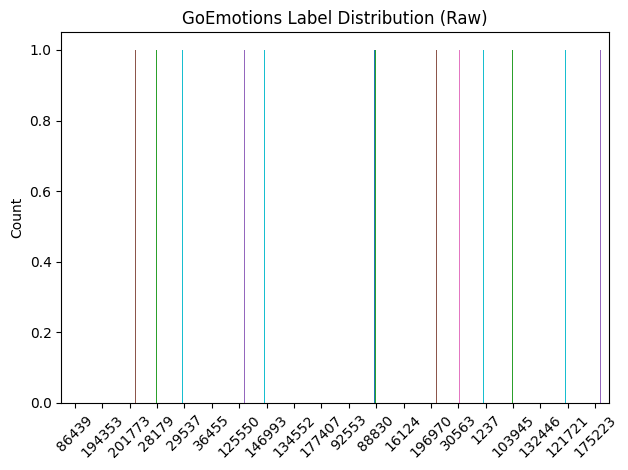

In [17]:
plt.figure(figsize=(12, 6))
balanced_df.head(20).plot(kind='bar', legend=False)  # Top 20 emotions
plt.title("GoEmotions Label Distribution (Raw)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:


# Initialize encoder for multi-label (if multiple emotions per text)
mlb = MultiLabelBinarizer(classes=balanced_df['emotion'].unique())

# Convert emotion strings to lists (if not already)
balanced_df['emotion_list'] = balanced_df['emotion'].apply(lambda x: [x])

# One-hot encode
emotion_onehot = mlb.fit_transform(balanced_df['emotion_list'])
emotion_cols = [f"emotion_{e}" for e in mlb.classes_]
emotion_df = pd.DataFrame(emotion_onehot, columns=emotion_cols)

In [19]:
print(balanced_df['label'].head())

86439     sadness
194353    sadness
201773    sadness
28179     sadness
29537     sadness
Name: label, dtype: object


In [20]:
from sklearn.preprocessing import LabelBinarizer

# Initialize encoder for single-label
lb = LabelBinarizer()

# One-hot encode
label_onehot = lb.fit_transform(balanced_df['label'])


In [21]:
print(lb.classes_)

['anger' 'disgust' 'fear' 'joy' 'nuetral' 'sadness' 'surprise']


In [22]:
label_cols = [f"label_{l}" for l in lb.classes_]
label_df = pd.DataFrame(label_onehot, columns=label_cols)

In [23]:
#final_df = pd.concat([balanced_df[['text']], emotion_df, label_df], axis=1)
final_df = pd.concat([balanced_df[['text']].reset_index(drop=True),
                      emotion_df.reset_index(drop=True),
                      label_df.reset_index(drop=True)],
                     axis=1)

In [24]:
print(len(final_df.columns))
print(final_df.columns)

35
Index(['text', 'emotion_remorse', 'emotion_disappointment', 'emotion_sadness',
       'emotion_embarrassment', 'emotion_grief', 'emotion_gratitude',
       'emotion_admiration', 'emotion_optimism', 'emotion_joy', 'emotion_love',
       'emotion_caring', 'emotion_amusement', 'emotion_relief',
       'emotion_desire', 'emotion_excitement', 'emotion_pride',
       'emotion_neutral', 'emotion_annoyance', 'emotion_disapproval',
       'emotion_anger', 'emotion_realization', 'emotion_curiosity',
       'emotion_confusion', 'emotion_surprise', 'emotion_disgust',
       'emotion_nervousness', 'emotion_fear', 'label_anger', 'label_disgust',
       'label_fear', 'label_joy', 'label_nuetral', 'label_sadness',
       'label_surprise'],
      dtype='object')


In [25]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [26]:
import re
import emoji
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def preprocess_text(text):
    """
    Ultimate text cleaner that handles:
    - All apostrophe types (straight, curly, smart quotes)
    - Contractions and common typos
    - Emojis and emotional cues
    - Edge cases (URLs, mentions, fragmented text)
    """
    if not isinstance(text, str):
        return ""

    try:
        # Normalize all apostrophe types to standard '
        text = re.sub(r'[‘’‛`´“”]', "'", text)

        # Convert emojis to text descriptions
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Comprehensive contraction handling (50+ cases)
        contractions = {
            # Standard contractions
            r"won't": "will not", r"can't": "cannot", r"i'm": "i am",
            r"isn't": "is not", r"don't": "do not", r"doesn't": "does not",
            r"didn't": "did not", r"shouldn't": "should not",
            r"wouldn't": "would not", r"couldn't": "could not",
            r"you're": "you are", r"they're": "they are",
            r"it's": "it is", r"that's": "that is",

            # Common typos and variants
            r"shouldnt": "should not", r"wont": "will not",
            r"cant": "cannot", r"im": "i am", r"hes": "he is",
            r"shes": "she is", r"thats": "that is",
            r"theres": "there is", r"its": "it is",

            # Special cases
            r"it\s+m\.": "it is",  # Handle "it m."
            r"(\w)'\s*$": r"\1",    # Fix trailing apostrophes
            r"i've": "i have", r"we've": "we have",
            r"let's": "let us", r"what's": "what is"
        }

        for pattern, replacement in contractions.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        # Remove URLs, mentions, and special characters
        text = re.sub(r'http\S+|www\S+|https\S+|@\w+|[^a-zA-Z\s.,!?_]', '', text)

        # Enhanced negation handling with word boundaries
        text = re.sub(r'\b(?:not|never|no|n\'t)\b\s+\b(\w+)\b', r'not_\1', text)

        # Final normalization
        tokens = word_tokenize(text.lower())
        clean_text = " ".join(tokens).strip()

        return clean_text

    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")
        return ""

# Apply to DataFrame
final_df['processed_text'] = final_df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [27]:
print(final_df.head())

                                                text  emotion_remorse  \
0  Sorry. I read that as newly white and it crack...                1   
1  Halep just can’t handle Kanepi, #1 is about to...                0   
2  [NAME] has broken his brain so bad he’s turnin...                0   
3               [NAME]. They’re grasping for straws!                0   
4              Whoops!! I totally didn’t realize ‍♀️                0   

   emotion_disappointment  emotion_sadness  emotion_embarrassment  \
0                       0                0                      0   
1                       1                0                      0   
2                       0                1                      0   
3                       0                0                      1   
4                       1                0                      0   

   emotion_grief  emotion_gratitude  emotion_admiration  emotion_optimism  \
0              0                  0                   0              

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
import torch
from torch.utils.data import Dataset

# Assuming your dataframe is called final_df
# Let's verify we have the right columns
print("Columns in final_df:", final_df.columns.tolist())

## STEP 1: Extract and prepare the emotion labels
# Get all emotion columns (both the one-hot and label columns)
emotion_cols = [col for col in final_df.columns if col.startswith('emotion_')]
label_cols = [col for col in final_df.columns if col.startswith('label_')]

Columns in final_df: ['text', 'emotion_remorse', 'emotion_disappointment', 'emotion_sadness', 'emotion_embarrassment', 'emotion_grief', 'emotion_gratitude', 'emotion_admiration', 'emotion_optimism', 'emotion_joy', 'emotion_love', 'emotion_caring', 'emotion_amusement', 'emotion_relief', 'emotion_desire', 'emotion_excitement', 'emotion_pride', 'emotion_neutral', 'emotion_annoyance', 'emotion_disapproval', 'emotion_anger', 'emotion_realization', 'emotion_curiosity', 'emotion_confusion', 'emotion_surprise', 'emotion_disgust', 'emotion_nervousness', 'emotion_fear', 'label_anger', 'label_disgust', 'label_fear', 'label_joy', 'label_nuetral', 'label_sadness', 'label_surprise', 'processed_text']


In [29]:
print(emotion_cols)
print(label_cols)

['emotion_remorse', 'emotion_disappointment', 'emotion_sadness', 'emotion_embarrassment', 'emotion_grief', 'emotion_gratitude', 'emotion_admiration', 'emotion_optimism', 'emotion_joy', 'emotion_love', 'emotion_caring', 'emotion_amusement', 'emotion_relief', 'emotion_desire', 'emotion_excitement', 'emotion_pride', 'emotion_neutral', 'emotion_annoyance', 'emotion_disapproval', 'emotion_anger', 'emotion_realization', 'emotion_curiosity', 'emotion_confusion', 'emotion_surprise', 'emotion_disgust', 'emotion_nervousness', 'emotion_fear']
['label_anger', 'label_disgust', 'label_fear', 'label_joy', 'label_nuetral', 'label_sadness', 'label_surprise']


emotion_neutral           10000
emotion_disgust           10000
emotion_fear               7237
emotion_disappointment     4680
emotion_annoyance          4097
emotion_curiosity          3353
emotion_disapproval        3171
emotion_admiration         3005
emotion_confusion          2863
emotion_nervousness        2763
emotion_anger              2732
emotion_sadness            2684
emotion_realization        2246
emotion_surprise           1538
emotion_amusement          1295
emotion_gratitude          1246
emotion_embarrassment      1176
emotion_remorse            1117
emotion_caring              808
emotion_joy                 783
emotion_optimism            782
emotion_love                773
emotion_excitement          655
emotion_desire              449
emotion_grief               343
emotion_relief              108
emotion_pride                96
dtype: int64


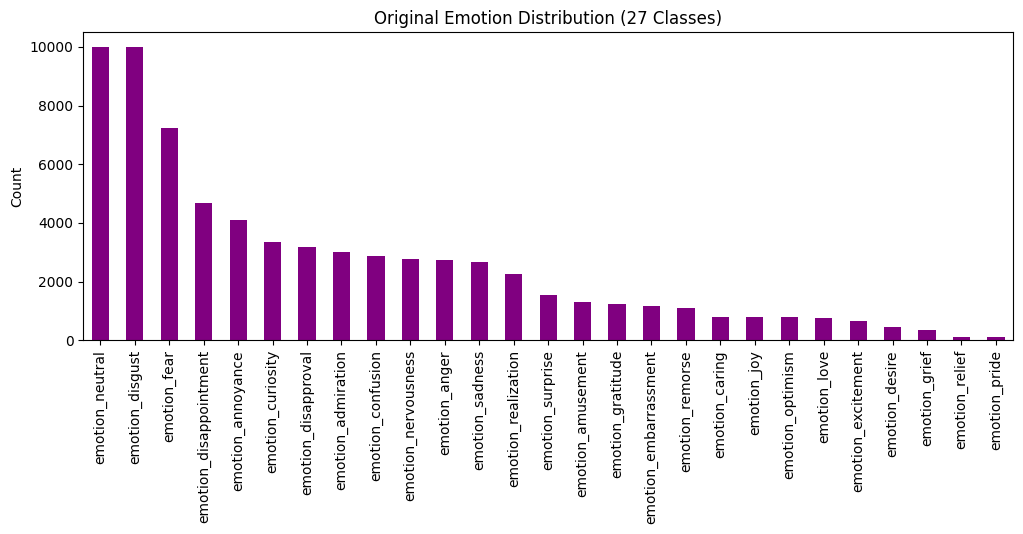

In [48]:
# Sum each emotion column (1 = present, 0 = absent)
emotion_distribution = final_df[['emotion_remorse', 'emotion_disappointment', 'emotion_grief', 'emotion_embarrassment', 'emotion_sadness', 'emotion_gratitude', 'emotion_optimism', 'emotion_desire', 'emotion_admiration', 'emotion_excitement', 'emotion_amusement', 'emotion_joy', 'emotion_love', 'emotion_caring', 'emotion_relief', 'emotion_pride', 'emotion_neutral', 'emotion_disapproval', 'emotion_annoyance', 'emotion_anger', 'emotion_realization', 'emotion_confusion', 'emotion_surprise', 'emotion_curiosity', 'emotion_disgust', 'emotion_fear', 'emotion_nervousness']].sum().sort_values(ascending=False)

# Print counts
print(emotion_distribution)

# Plot
emotion_distribution.plot(kind='bar', figsize=(12, 4), color='purple')
plt.title("Original Emotion Distribution (27 Classes)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [31]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Data Preparation with Train-Validation-Test Split
emotion_columns = [col for col in final_df.columns if col.startswith('emotion_')]
final_df[emotion_columns] = final_df[emotion_columns].apply(pd.to_numeric, errors='coerce')
final_df['emotion_label'] = final_df[emotion_columns].idxmax(axis=1).str.replace('emotion_', '')

label_encoder = LabelEncoder()
final_df['encoded_label'] = label_encoder.fit_transform(final_df['emotion_label'])

In [32]:
# 2. Dataset and DataLoader with Three-way Split
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Initialize tokenizer and split data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
texts = final_df['processed_text'].values
labels = final_df['encoded_label'].values

# Create full dataset and split into train, validation, and test sets
full_dataset = EmotionDataset(texts, labels, tokenizer)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = int(0.1 * dataset_size)    # 10% for validation
test_size = dataset_size - train_size - val_size  # 10% for testing

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"Dataset sizes: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Dataset sizes: Train=56000, Validation=7000, Test=7000


In [33]:
# 3. Model Initialization with Class Weights
class_counts = final_df['encoded_label'].value_counts().sort_index().values
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_encoder.classes_),
    problem_type="single_label_classification"
).to(device)

# 4. Enhanced Training Setup
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs = 6
total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# 5. Improved Training Loop with Metrics Tracking
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    epoch_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f'Train Epoch {epoch+1}')

    for batch in progress_bar:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        epoch_train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    avg_train_loss = epoch_train_loss / len(train_dataloader)

    # Validation Phase
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Validation Epoch {epoch+1}'):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)

    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print("Validation Classification Report:")
    print(val_report)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved new best model")

# 6. Evaluate on Test Set
print("\nEvaluating on Test Set")
model.load_state_dict(torch.load("best_model.pt"))  # Load the best model based on validation
model.eval()
test_loss = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Test Evaluation'):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        test_loss += outputs.loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(batch['labels'].cpu().numpy())

avg_test_loss = test_loss / len(test_dataloader)
test_report = classification_report(all_test_labels, all_test_preds, target_names=label_encoder.classes_)

print(f"Test Loss: {avg_test_loss:.4f}")
print("Test Classification Report:")
print(test_report)

# 7. Save Final Model and Components
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'class_weights': class_weights.cpu(),
    'tokenizer_config': tokenizer.init_kwargs
}, 'emotion_classifier.pth')

tokenizer.save_pretrained('./emotion_tokenizer')

Validation Epoch 1: 100%|██████████| 219/219 [00:24<00:00,  9.10it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 1
Train Loss: 2.4286 | Val Loss: 1.9716
Validation Classification Report:
                precision    recall  f1-score   support

    admiration       0.51      0.47      0.49       324
     amusement       0.43      0.63      0.51       136
         anger       0.33      0.27      0.30       283
     annoyance       0.17      0.01      0.01       432
        caring       0.00      0.00      0.00        78
     confusion       0.38      0.22      0.28       291
     curiosity       0.42      0.67      0.52       358
        desire       0.38      0.09      0.14        35
disappointment       0.20      0.20      0.20       452
   disapproval       0.30      0.24      0.27       296
       disgust       0.46      0.78      0.58      1033
 embarrassment       0.83      0.09      0.16       114
    excitement       0.00      0.00      0.00        61
          fear       0.63      0.72      0.67       690
     gratitude       0.59      0.72      0.65       121
         grief       0

Validation Epoch 2: 100%|██████████| 219/219 [00:24<00:00,  9.08it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 2
Train Loss: 1.8569 | Val Loss: 1.8395
Validation Classification Report:
                precision    recall  f1-score   support

    admiration       0.54      0.52      0.53       324
     amusement       0.45      0.65      0.53       136
         anger       0.35      0.27      0.30       283
     annoyance       0.28      0.10      0.15       432
        caring       0.23      0.04      0.07        78
     confusion       0.33      0.34      0.33       291
     curiosity       0.45      0.52      0.48       358
        desire       0.38      0.17      0.24        35
disappointment       0.28      0.21      0.24       452
   disapproval       0.34      0.24      0.28       296
       disgust       0.50      0.84      0.63      1033
 embarrassment       0.51      0.17      0.25       114
    excitement       0.38      0.08      0.14        61
          fear       0.70      0.75      0.72       690
     gratitude       0.65      0.70      0.68       121
         grief       0

Validation Epoch 3: 100%|██████████| 219/219 [00:24<00:00,  9.08it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 3
Train Loss: 1.6450 | Val Loss: 1.7911
Validation Classification Report:
                precision    recall  f1-score   support

    admiration       0.56      0.53      0.54       324
     amusement       0.49      0.58      0.53       136
         anger       0.43      0.23      0.30       283
     annoyance       0.29      0.07      0.11       432
        caring       0.38      0.19      0.25        78
     confusion       0.38      0.26      0.31       291
     curiosity       0.41      0.68      0.51       358
        desire       0.33      0.17      0.23        35
disappointment       0.24      0.24      0.24       452
   disapproval       0.34      0.33      0.34       296
       disgust       0.60      0.86      0.70      1033
 embarrassment       0.45      0.20      0.28       114
    excitement       0.14      0.02      0.03        61
          fear       0.73      0.81      0.77       690
     gratitude       0.66      0.72      0.69       121
         grief       0

Validation Epoch 4: 100%|██████████| 219/219 [00:24<00:00,  9.10it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 4
Train Loss: 1.4885 | Val Loss: 1.7837
Validation Classification Report:
                precision    recall  f1-score   support

    admiration       0.58      0.52      0.55       324
     amusement       0.48      0.60      0.53       136
         anger       0.33      0.39      0.36       283
     annoyance       0.21      0.16      0.18       432
        caring       0.33      0.17      0.22        78
     confusion       0.35      0.31      0.33       291
     curiosity       0.44      0.59      0.50       358
        desire       0.25      0.20      0.22        35
disappointment       0.25      0.27      0.26       452
   disapproval       0.34      0.33      0.33       296
       disgust       0.67      0.83      0.74      1033
 embarrassment       0.43      0.25      0.32       114
    excitement       0.21      0.07      0.10        61
          fear       0.72      0.87      0.79       690
     gratitude       0.63      0.71      0.67       121
         grief       0

Validation Epoch 5: 100%|██████████| 219/219 [00:24<00:00,  9.10it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 5
Train Loss: 1.3761 | Val Loss: 1.8107
Validation Classification Report:
                precision    recall  f1-score   support

    admiration       0.57      0.51      0.54       324
     amusement       0.49      0.56      0.52       136
         anger       0.35      0.29      0.32       283
     annoyance       0.26      0.13      0.17       432
        caring       0.29      0.21      0.24        78
     confusion       0.31      0.34      0.32       291
     curiosity       0.45      0.56      0.50       358
        desire       0.29      0.20      0.24        35
disappointment       0.26      0.25      0.26       452
   disapproval       0.32      0.33      0.33       296
       disgust       0.66      0.85      0.74      1033
 embarrassment       0.47      0.25      0.33       114
    excitement       0.25      0.08      0.12        61
          fear       0.70      0.89      0.78       690
     gratitude       0.63      0.70      0.66       121
         grief       0

Validation Epoch 6: 100%|██████████| 219/219 [00:24<00:00,  9.10it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(


Epoch 6
Train Loss: 1.2988 | Val Loss: 1.8221
Validation Classification Report:
                precision    recall  f1-score   support

    admiration       0.57      0.52      0.54       324
     amusement       0.48      0.56      0.52       136
         anger       0.32      0.29      0.31       283
     annoyance       0.24      0.15      0.19       432
        caring       0.29      0.22      0.25        78
     confusion       0.33      0.32      0.32       291
     curiosity       0.44      0.56      0.49       358
        desire       0.26      0.20      0.23        35
disappointment       0.27      0.25      0.26       452
   disapproval       0.33      0.32      0.32       296
       disgust       0.66      0.86      0.75      1033
 embarrassment       0.43      0.25      0.32       114
    excitement       0.26      0.10      0.14        61
          fear       0.72      0.87      0.79       690
     gratitude       0.65      0.70      0.67       121
         grief       0

Test Evaluation: 100%|██████████| 219/219 [00:24<00:00,  9.09it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Test Loss: 1.8333
Test Classification Report:
                precision    recall  f1-score   support

    admiration       0.43      0.47      0.45       276
     amusement       0.45      0.64      0.52       127
         anger       0.32      0.33      0.33       287
     annoyance       0.19      0.15      0.17       398
        caring       0.22      0.14      0.17        71
     confusion       0.39      0.33      0.36       288
     curiosity       0.37      0.56      0.44       301
        desire       0.30      0.22      0.25        46
disappointment       0.28      0.28      0.28       467
   disapproval       0.29      0.31      0.30       323
       disgust       0.66      0.82      0.73       978
 embarrassment       0.34      0.19      0.25       109
    excitement       0.29      0.11      0.16        72
          fear       0.70      0.87      0.78       681
     gratitude       0.59      0.68      0.63       120
         grief       1.00      0.02      0.05        41
 

('./emotion_tokenizer/tokenizer_config.json',
 './emotion_tokenizer/special_tokens_map.json',
 './emotion_tokenizer/vocab.txt',
 './emotion_tokenizer/added_tokens.json')

In [35]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(batch['labels'].cpu().numpy())


y_true = np.array(final_labels)
y_pred = np.array(final_preds)

# 1) Overall accuracy
acc = accuracy_score(y_true, y_pred)

# 2) Precision, recall, F1 (choose averaging scheme: 'macro', 'micro', or 'weighted')
precision = precision_score(y_true, y_pred, average='macro')
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy : {acc:.4f}")
print(f"Precision (macro-average): {precision:.4f}")
print(f"Recall    (macro-average): {recall:.4f}")
print(f"F1        (macro-average): {f1:.4f}\n")


label_names = label_encoder.classes_
print(classification_report(y_true, y_pred, target_names=label_names))


Accuracy : 0.4723
Precision (macro-average): 0.3956
Recall    (macro-average): 0.3565
F1        (macro-average): 0.3516

                precision    recall  f1-score   support

    admiration       0.43      0.47      0.45       276
     amusement       0.45      0.64      0.52       127
         anger       0.32      0.33      0.33       287
     annoyance       0.19      0.15      0.17       398
        caring       0.22      0.14      0.17        71
     confusion       0.39      0.33      0.36       288
     curiosity       0.37      0.56      0.44       301
        desire       0.30      0.22      0.25        46
disappointment       0.28      0.28      0.28       467
   disapproval       0.29      0.31      0.30       323
       disgust       0.66      0.82      0.73       978
 embarrassment       0.34      0.19      0.25       109
    excitement       0.29      0.11      0.16        72
          fear       0.70      0.87      0.78       681
     gratitude       0.59      0.68   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [47]:
from collections import Counter

# (you already have y_true as a 1D numpy array)
total_examples = len(y_true)
print(f"Total examples in test set: {total_examples}\n")

# Count how many times each label appears
label_counts = Counter(y_true)

print("Test‑set label distribution:")
for label_idx, count in label_counts.items():
    label_name = label_encoder.inverse_transform([label_idx])[0]
    pct = count / total_examples * 100
    print(f"  {label_name:>15s}: {count:4d} examples  ({pct:5.2f}%)")


Total examples in test set: 7000

Test‑set label distribution:
          neutral: 1087 examples  (15.53%)
           desire:   46 examples  ( 0.66%)
        gratitude:  120 examples  ( 1.71%)
      disapproval:  323 examples  ( 4.61%)
            anger:  287 examples  ( 4.10%)
          disgust:  978 examples  (13.97%)
        annoyance:  398 examples  ( 5.69%)
             fear:  681 examples  ( 9.73%)
              joy:   71 examples  ( 1.01%)
   disappointment:  467 examples  ( 6.67%)
        curiosity:  301 examples  ( 4.30%)
           relief:   14 examples  ( 0.20%)
      realization:  244 examples  ( 3.49%)
        amusement:  127 examples  ( 1.81%)
          sadness:  282 examples  ( 4.03%)
      nervousness:  278 examples  ( 3.97%)
         surprise:  144 examples  ( 2.06%)
       admiration:  276 examples  ( 3.94%)
             love:   85 examples  ( 1.21%)
            grief:   41 examples  ( 0.59%)
    embarrassment:  109 examples  ( 1.56%)
           caring:   71 examples  

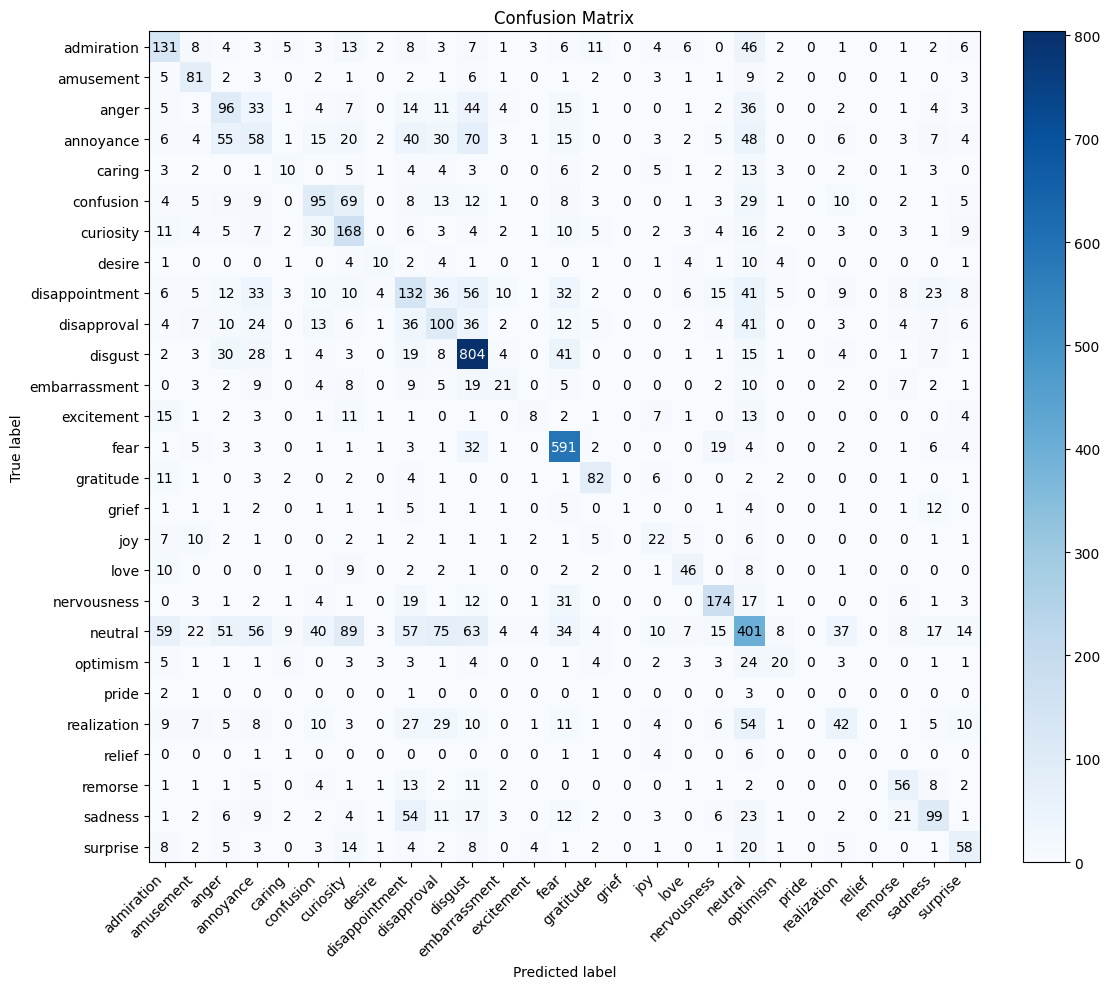

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a bigger figure (e.g. 8×6 inches)
fig, ax = plt.subplots(figsize=(12, 10))

# Show the matrix with a blue colormap
cax = ax.imshow(cm, cmap='Blues', interpolation='nearest')

# Add a colorbar to the side
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

# Labels and title
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Tick marks for class names
ax.set_xticks(range(len(label_names)))
ax.set_xticklabels(label_names, rotation=45, ha='right')
ax.set_yticks(range(len(label_names)))
ax.set_yticklabels(label_names)

# Annotate each cell with the raw count (white text on dark cells)
for i in range(len(label_names)):
    for j in range(len(label_names)):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, cm[i, j], ha='center', va='center', color=color)

plt.tight_layout()
plt.show()


In [38]:
# Final evaluation on validation set

print(f"\nFinal Model Validation Accuracy: {acc:.4f}")


Final Model Validation Accuracy: 0.4723


In [ ]:
from google.colab import files
import os
import shutil

# 1. Create a directory for all model files
model_dir = './emotion_model'
os.makedirs(model_dir, exist_ok=True)

# 2. Save model components
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'num_labels': len(label_encoder.classes_)
}, os.path.join(model_dir, 'model_state.pth'))

# 3. Save tokenizer
tokenizer.save_pretrained(model_dir)

# 4. Create a zip archive for easy download
shutil.make_archive('emotion_model', 'zip', model_dir)

# 5. Download the zip file
files.download('emotion_model.zip')

print("Model files have been saved and downloaded successfully!")

In [39]:
import torch

def predict_emotion(text, model_path='./emotion_classifier.pth', tokenizer_path='./emotion_tokenizer'):
    # Load components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)

    # Load model
    # Set weights_only=False to load the entire checkpoint (including label_encoder)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)  # Changed line
    label_encoder = checkpoint['label_encoder']

    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(label_encoder.classes_)
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Tokenize input
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Predict
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    # Get top prediction
    pred_idx = np.argmax(probs)
    emotion = label_encoder.inverse_transform([pred_idx])[0]
    confidence = probs[pred_idx]

    return {
        'text': text,
        'emotion': emotion,
        'confidence': float(confidence),
        'all_probabilities': {label: float(prob) for label, prob in zip(label_encoder.classes_, probs)}
    }

In [40]:
# Example prediction
result = predict_emotion("The meeting will be held at 3pm in conference room B.")
print(f"Predicted emotion: {result['emotion']} (confidence: {result['confidence']:.2f})")
print("All probabilities:", result['all_probabilities'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted emotion: neutral (confidence: 0.77)
All probabilities: {'admiration': 0.030687840655446053, 'amusement': 0.002171584405004978, 'anger': 0.0023291304241865873, 'annoyance': 0.006158590316772461, 'caring': 0.013645232655107975, 'confusion': 0.005787220783531666, 'curiosity': 0.01048981212079525, 'desire': 0.007981916889548302, 'disappointment': 0.0034344340674579144, 'disapproval': 0.0035910168662667274, 'disgust': 0.0006435717223212123, 'embarrassment': 0.0027651311829686165, 'excitement': 0.0395401231944561, 'fear': 0.004299395252019167, 'gratitude': 0.003787267254665494, 'grief': 0.0011579872807487845, 'joy': 0.021633660420775414, 'love': 0.002110785339027643, 'nervousness': 0.0036208322271704674, 'neutral': 0.76960289478302, 'optimism': 0.01862071454524994, 'pride': 0.0018963045440614223, 'realization': 0.022997746244072914, 'relief': 0.0021851470228284597, 'remorse': 0.0010018701432272792, 'sadness': 0.0024231518618762493, 'surprise': 0.015436653979122639}
